In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys
import datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

processeddir = "../data/processed/"
df = pd.read_csv(os.path.join(processeddir,"nyctaxiclean.csv"), dtype={"store_and_fwd_flag": "object"})
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
grouped_df = df.groupby("pickup_neighbourhood")

In [15]:
grouped_df.count().sort_values("medallion", ascending=False)

,Unnamed: 0,medallion,hack_license,vendor_id_x,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,...,dropoff_latitude,vendor_id_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,dropoff_neighbourhood
pickup_neighbourhood,,,,,,,,,,,,,,,,,,,,,
Upper East Side South,566047,566047,566047,566047,566047,288337,566047,566047,566047,566047,...,566047,566047,566047,566047,566047,566047,566047,566047,566047,566047
Midtown Center,526084,526084,526084,526084,526084,262834,526084,526084,526084,526084,...,526084,526084,526084,526084,526084,526084,526084,526084,526084,526084
Upper East Side North,510157,510157,510157,510157,510157,256132,510157,510157,510157,510157,...,510157,510157,510157,510157,510157,510157,510157,510157,510157,510157
Midtown East,506596,506596,506596,506596,506596,249295,506596,506596,506596,506596,...,506596,506596,506596,506596,506596,506596,506596,506596,506596,506596
Union Sq,505786,505786,505786,505786,505786,252586,505786,505786,505786,505786,...,505786,505786,505786,505786,505786,505786,505786,505786,505786,505786
Murray Hill,504911,504911,504911,504911,504911,251391,504911,504911,504911,504911,...,504911,504911,504911,504911,504911,504911,504911,504911,504911,504911
Times Sq/Theatre District,488156,488156,488156,488156,488156,242872,488156,488156,488156,488156,...,488156,488156,488156,488156,488156,488156,488156,488156,488156,488156
East Village,480678,480678,480678,480678,480678,240096,480678,480678,480678,480678,...,480678,480678,480678,480678,480678,480678,480678,480678,480678,480678
Clinton East,462361,462361,462361,462361,462361,232157,462361,462361,462361,462361,...,462361,462361,462361,462361,462361,462361,462361,462361,462361,462361


In [4]:
# investigate Midtown Center timeseries
# discretize to qtr hour

df['qtr_hour'] = df['pickup_datetime'].apply(lambda x: datetime.datetime(x.year, x.month, x.day, x.hour,15*(x.minute // 15)))
midtc_df = df.loc[df["pickup_neighbourhood"] == 'Midtown Center']


In [5]:
# model activity as number of pickups
midtc_df = midtc_df[["qtr_hour", "medallion"]].groupby("qtr_hour").count()

array([ 35,  26,  28, ..., 245, 203, 178])

In [75]:
#unit root test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(midtc_df['medallion'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#ADF statistic is less than the critical value for 1% p-value: p-value is zero. 
#reject the null hypothesis (unit-root): accept we have a stationary timeseries

ADF Statistic: -11.310944
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


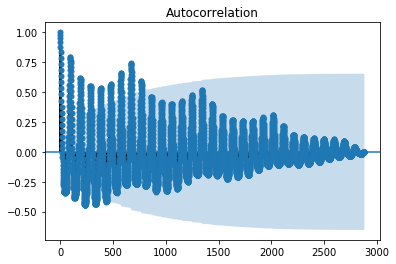

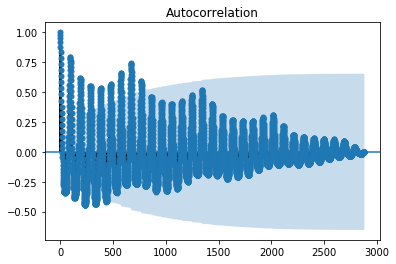

In [22]:
plot_acf(midtc_df)

0.0

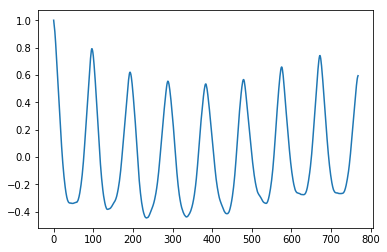

In [89]:
# inspect the period of the peaks
mt_acf = acf(midtc_df, nlags=8*24*4) #8 days
plt.plot(mt_acf[0])

In [83]:
#one peak per day; it's probably on the daily mark but let's check
daylength = 4 * 24
halfday = int(daylength/2)
peak_index = []
for i in range(7):
    #find peaks in a window starting from halfway through the first day
    peak_index.append(i*daylength + halfday + np.argmax(mt_acf[i*daylength + halfday: (i+1)*daylength + halfday]))
    
print(peak_index)
print(np.asarray(peak_index)/daylength)

[96, 193, 288, 384, 479, 575, 672]
[1.         2.01041667 3.         4.         4.98958333 5.98958333
 7.        ]


As expected, there is a strong daily seasonality to this time series. The strongest correlations are 1 day lag and 7 day lag (weekly component)

<Figure size 432x288 with 0 Axes>

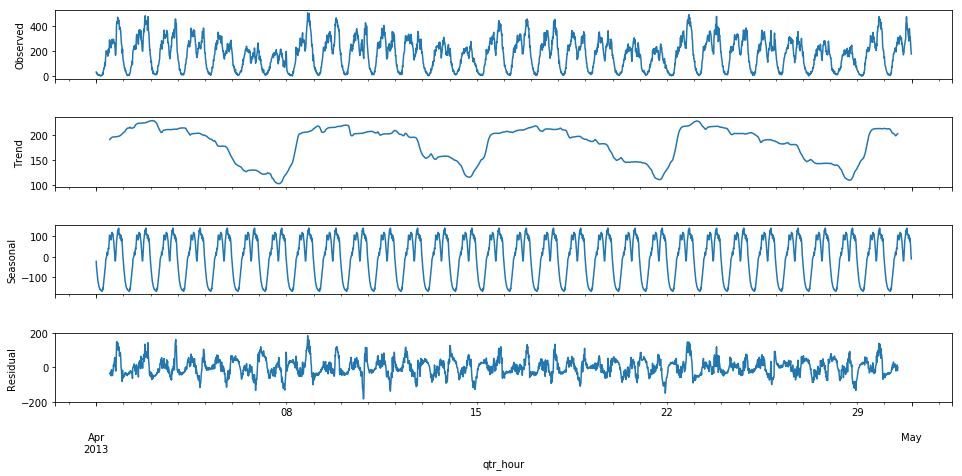

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(midtc_df, freq=4*24) #daily  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
#there is also a weekly component

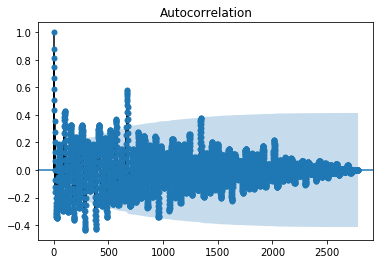

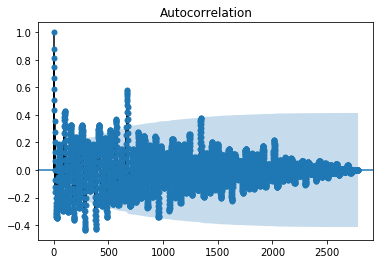

In [160]:
#inspect residuals
plot_acf(decomposition.resid.dropna())

#too much autocorrelation in the residuals ; we have neglected the weekly component


There is still a seasonal component left in the trend. Try weekly seasonality

<Figure size 432x288 with 0 Axes>

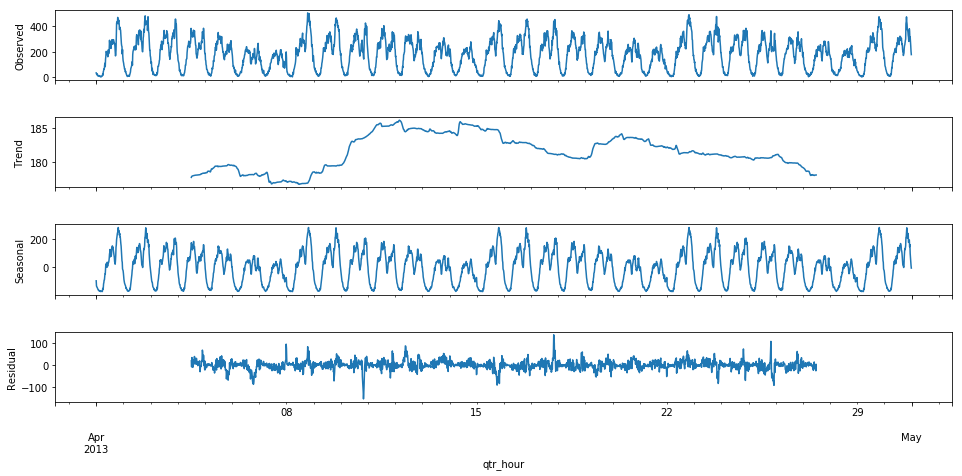

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_decomposition = seasonal_decompose(midtc_df, freq=7*4*24) #weekly  
fig = plt.figure()  
fig = weekly_decomposition.plot()  
fig.set_size_inches(15, 8)

#weekly component 

In [174]:
#examine the residuals
print( "Peak at {}".format(50+np.argmax(acf(weekly_decomposition.resid.dropna(), nlags=8*24*4)[50:])))
#we are now neglecting daily seasonality

Peak at 96


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


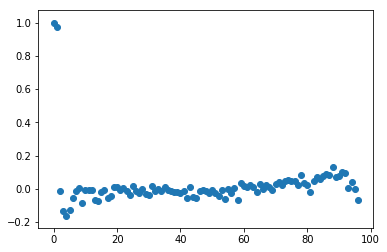

In [187]:
mt_pacf = pacf(midtc_df, nlags=8*24*4) #8 days


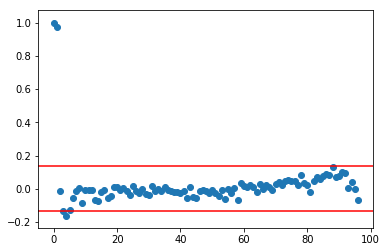

In [192]:
#significance level of pacf with N samples

N = len(midtc_df)
sig = (np.exp(2*1.96/np.sqrt(N-3)-1)/(np.exp(2*1.96/np.sqrt(N-3)+1)))

plt.scatter(np.arange(24*4+1), mt_pacf[:24*4+1])
plt.axhline(y=sig, color='r', linestyle='-')
plt.axhline(y=-sig, color='r', linestyle='-')

In [201]:
#find significant components
np.argwhere(abs(mt_pacf[:24*7]) > sig)

array([[ 0],
       [ 1],
       [ 4],
       [97],
       [98]])

Peaks are at lag 1
and 97


In [ ]:
#%pdb on
# PACF indicates a model AR(1-4) with seasonality of day. Potential for MA component given damped sin effect
# ACF indicates additional seasonality component of week

from statsmodels.tsa.statespace.sarimax  import SARIMAX
#grid search using AIC
models = []
results = []

seasonal_options = [(1,0,0,96), (0,0,1,96), (1,0,1,96)] # order 7 (weekly) doesn't converge (singular matrix)

for p in range(1,5):
    for q in range(0,5):
        for s in range(3):
            print(p,q,s)
            try:
                models.append(SARIMAX(midtc_df.values, order=(p,0,q), seasonal_order=seasonal_options[s]))
                results.append(models[-1].fit())
            except Exception as e:
                print(e)
                results.append(None)


1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 3 0
1 3 1
1 3 2
1 4 0
1 4 1
1 4 2
2 0 0
2 0 1
2 0 2
2 1 0
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
2 1 1
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
2 1 2
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
2 2 0


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)


2 2 1
2 2 2
2 3 0


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 3 1


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 3 2
2 4 0


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 4 1


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 4 2
3 0 0
3 0 1
3 0 2
3 1 0
3 1 1
3 1 2


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 2 0
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
3 2 1
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
3 2 2
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
3 3 0
3 3 1
3 3 2
3 4 0


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 4 1
3 4 2


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 0 0
4 0 1
4 0 2
4 1 0
4 1 1
4 1 2


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 0


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 1


/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 2


In [10]:
results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2880
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 96)   Log Likelihood              -13386.220
Date:                            Wed, 02 May 2018   AIC                          26778.439
Time:                                    04:05:09   BIC                          26796.336
Sample:                                         0   HQIC                         26784.890
                                           - 2880                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9864      0.002    400.326      0.000       0.982       0.991
ar.S.L96       0.3216      0.015     21.036      0.000       0.292       0.352
sigma2       634.6983     12.177     52.121      0.000     610.831     658.566
===================================================================================
Ljung-Box (Q):                      171.83   Jarque-Bera (JB):               393.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.23
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/tdm/git/nyctaxi/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(26000, 30000)

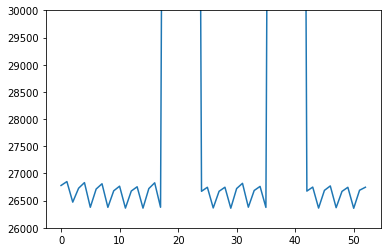

In [29]:
#pick best model based on AIC & Q stat
from matplotlib import pyplot as plt
aic = pd.Series([x.aic if x else 50000 for x in results])
aic = aic.fillna(50000)
np.argmin(aic)
ax = aic.plot()
ax.set_ylim((26000,30000))

In [32]:
# pick simplest model with AIC below 24000
best_order = (1,0,1)
best_seasonal = seasonal_options[2] # (1,0,1,96)

